# Data Science Capstone Final Notebook

### This notebook will analyse the similarity of postcodes in London to New York to determine a preferred secondment location based on ameneties nearby, levaraging the foursquare API.

### We will require the postcodes of the cities in question, longitude and latitude for use with the 4square API and a list of venues and their categorical type. We want to perform a cosine similarity to find the areas of New York that are similar to a selected borough of London. For example if the employee lives in Camden, where in New York will offer the most similar set of ameneties.

In [1]:
# Import Modules that we require
import pandas as pd
import numpy as np
import json 
import requests 

# import k-means from clustering stage and obtain silhouette_score for analysing best value of K.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
!conda install -c conda-forge matplotlib-venn --yes
from matplotlib_venn import venn2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# For the website Scraping and Geolocation
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge lxml --yes
from lxml import etree

print('Modules Imported')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-

In [2]:
# We have to scrape website data for our postal and zip codes.
# London
page = pd.read_html('https://en.wikipedia.org/wiki/List_of_London_boroughs')
df_London = pd.DataFrame(page[0])

df_London = df_London[['Borough']]
df_London = df_London.rename(columns={'Borough':'Neighborhood'})

# Tidy up some strings
df_London['Neighborhood'][0] = 'Barking and Dagenham'
df_London['Neighborhood'][9] = 'Greenwich'
df_London['Neighborhood'][11] = 'Hammersmith and Fulham'

strL = ['London' for x in range(df_London.shape[0])]
df_London = df_London.assign(City = strL).reset_index()
df_London = df_London[['Neighborhood','City']]

# Final Output
print('London contains ' + str(df_London.shape[0]) + ' Neighborhoods for analysis')
df_London.head()

London contains 32 Neighborhoods for analysis


Neighborhood    City
0  Barking and Dagenham  London
1                Barnet  London
2                Bexley  London
3                 Brent  London
4               Bromley  London

In [3]:
# We have to scrape website data for our postal and zip codes.
# New York
page = pd.read_html('https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm')
df_NY = pd.DataFrame(page[0])
df_NY = df_NY[['Neighborhood']]

# Split multiple neighborhoods
dfNs = df_NY["Neighborhood"].str.split(" and ", n = 1, expand = True)
df1 = dfNs[[0]].dropna().rename(columns={0:'Neighborhood'})
df2 = dfNs[[1]].dropna().rename(columns={1:'Neighborhood'})
df_NY = pd.concat([df1,df2],axis = 0).reset_index()
df_NY = df_NY[['Neighborhood']]

strNY = ['New York' for x in range(df_NY.shape[0])]
df_NY = df_NY.assign(City = strNY).reset_index()
df_NY = df_NY[['Neighborhood','City']]

# Final Output
print('New York, NY has ' + str(df_NY.shape[0]) + ' Neighborhoods for analysis')
df_NY.head()

New York, NY has 54 Neighborhoods for analysis


Neighborhood      City
0  Central Bronx  New York
1     Bronx Park  New York
2    High Bridge  New York
3    Hunts Point  New York
4    Kingsbridge  New York

In [4]:
def LatLongSearch(df):
    
    latitude = np.zeros(df.shape[0])
    longitude = np.zeros(df.shape[0])
    
    for n in range(df.shape[0]):
        
        # Use the neighborhood and city to get the geolocations
        try:
            address = 'Borough ' + str(df['Neighborhood'][n]) + ', ' + str(df['City'][n])
            geolocator = Nominatim(user_agent="geo_explorer")
            location = geolocator.geocode(address)
            latitude[n] = location.latitude
            longitude[n] = location.longitude
        except:
            try:
                address = str(df['Neighborhood'][n]) + ', ' + str(df['City'][n])
                geolocator = Nominatim(user_agent="geo_explorer")
                location = geolocator.geocode(address)
                latitude[n] = location.latitude
                longitude[n] = location.longitude
            except:
                geolocator = Nominatim(user_agent="geo_explorer")
                location = geolocator.geocode({"street":df['Neighborhood'][n],"city":df['City'][n]})
                latitude[n] = location.latitude
                longitude[n] = location.longitude
        
        
    df = df.assign(Latitude = latitude)
    df = df.assign(Longitude = longitude)

    return df

In [5]:
df_NY = LatLongSearch(df_NY)

In [6]:
df_NY.head()

Neighborhood      City   Latitude  Longitude
0  Central Bronx  New York  40.846371 -73.899220
1     Bronx Park  New York  40.858847 -73.875904
2    High Bridge  New York  40.842443 -73.931653
3    Hunts Point  New York  40.812601 -73.884025
4    Kingsbridge  New York  40.878705 -73.905141

In [7]:
df_London = LatLongSearch(df_London)

In [8]:
df_London.head()

Neighborhood    City   Latitude  Longitude
0  Barking and Dagenham  London  51.554117   0.150504
1                Barnet  London  51.612523  -0.211444
2                Bexley  London  51.461969   0.145699
3                 Brent  London  51.563826  -0.275760
4               Bromley  London  51.366857   0.061709

### Let's get 100 venues within a mile of each neighbourhood and visualise our cities 

In [9]:
# Here is our Function to scan the Coordinates
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    ''' Our Function will get up to 100 nearest venues in a 1600 metre radius of the coordinates'''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            1600, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [10]:
# Our Foursquare Creds
CLIENT_ID = '3PUCFEWG2OS5ETYV55CEWNR1IG0DOE2ROZOJ1UFBZZN1V5OX' # your Foursquare ID
CLIENT_SECRET = '2X3231Z44OHX1TP5UYO1GMIXSCTPVAT13TAEGZNJFYOVPLHI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 3PUCFEWG2OS5ETYV55CEWNR1IG0DOE2ROZOJ1UFBZZN1V5OX
CLIENT_SECRET:2X3231Z44OHX1TP5UYO1GMIXSCTPVAT13TAEGZNJFYOVPLHI


In [13]:
# Scan all the Neighbourhoods in London
London_venues = getNearbyVenues(names=df_London['Neighborhood'],
                                   latitudes=df_London['Latitude'],
                                   longitudes=df_London['Longitude']
                                  )
London_venues = London_venues.drop_duplicates(subset='Venue',keep='first')
London_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Barking and Dagenham              51.554117                0.150504   
1  Barking and Dagenham              51.554117                0.150504   
2  Barking and Dagenham              51.554117                0.150504   
3  Barking and Dagenham              51.554117                0.150504   
4  Barking and Dagenham              51.554117                0.150504   

          Venue  Venue Latitude  Venue Longitude          Venue Category  
0  Central Park       51.559560         0.161981                    Park  
1            BP       51.549951         0.161963             Gas Station  
2       Iceland       51.560578         0.147685           Grocery Store  
3         wilko       51.541002         0.148898  Furniture / Home Store  
4          Asda       51.565751         0.143392             Supermarket

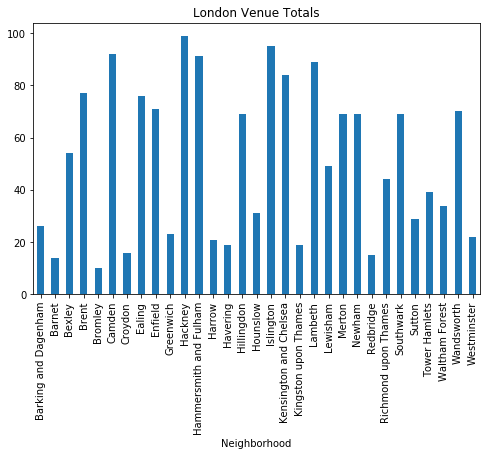

In [14]:
# Check how many venues we found per Neighborhood
London_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().plot(kind='bar',legend = False,title = 'London Venue Totals',figsize = (8,5))

In [15]:
# create map of Venues using latitude and longitude values
map_london = folium.Map(location=[df_London['Latitude'].mean(), df_London['Longitude'].mean()], zoom_start=10, width='50%', height='50%')

# add markers to map
for lat, lng, neighborhood in zip(London_venues['Venue Latitude'], London_venues['Venue Longitude'], London_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        parse_html=False).add_to(map_london)  
    
map_london

In [17]:
# Scan all the Neighbourhoods in New York
NY_venues = getNearbyVenues(names=df_NY['Neighborhood'],
                                   latitudes=df_NY['Latitude'],
                                   longitudes=df_NY['Longitude']
                                  )
NY_venues = NY_venues.drop_duplicates(subset='Venue',keep='first')
NY_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Central Bronx              40.846371               -73.89922   
1  Central Bronx              40.846371               -73.89922   
2  Central Bronx              40.846371               -73.89922   
3  Central Bronx              40.846371               -73.89922   
4  Central Bronx              40.846371               -73.89922   

                         Venue  Venue Latitude  Venue Longitude  \
0                     7-Eleven       40.846679       -73.902036   
1          Napoli's Best Pizza       40.846903       -73.896335   
2          Calabria Pork Store       40.854145       -73.888776   
3              North Star Cafe       40.843336       -73.886982   
4  Arthur Avenue Retail Market       40.854157       -73.888179   

       Venue Category  
0   Convenience Store  
1         Pizza Place  
2  Italian Restaurant  
3                Café  
4              Market

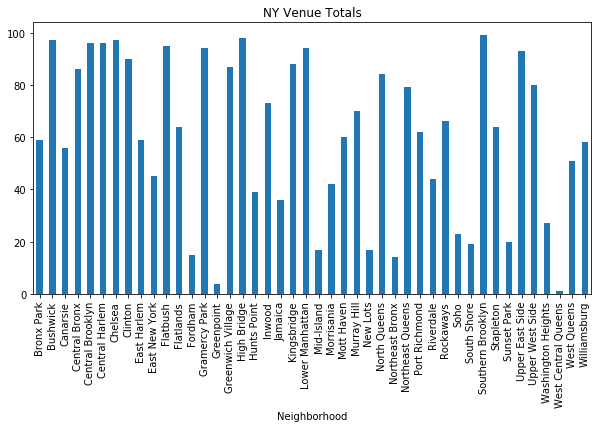

In [18]:
# Check how many venues we found per Neighborhood
NY_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().plot(kind='bar',legend = False,title = 'NY Venue Totals',figsize = (10,5))

In [19]:
# create map of Venues using latitude and longitude values
map_ny = folium.Map(location=[40.7831, -73.9712], zoom_start=10, width='50%', height='50%')

# add markers to map
for lat, lng, neighborhood in zip(NY_venues['Venue Latitude'], NY_venues['Venue Longitude'], NY_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        parse_html=False).add_to(map_ny)  
    
map_ny

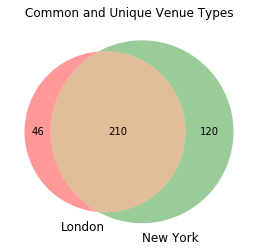

In [21]:
# Make a venn diagram of common and unique venues
set1=London_venues
set2=NY_venues
venn2([set(set1['Venue Category']), set(set2['Venue Category'])], set_labels = ('London', 'New York'))
plt.title('Common and Unique Venue Types')
plt.show()

In [22]:
# Define a common venue type between two cities for analysis
def cvt(df1,df2):
    common_venue_types = list(set(df1['Venue Category']) & set(df2['Venue Category']))
    return common_venue_types
 

### Let's compare the cities based on the common values

In [23]:
# Reduce to only common venue types
common_LonNY = cvt(London_venues,NY_venues)
London_venues = London_venues[London_venues['Venue Category'].isin(common_LonNY)]
NY_venues = NY_venues[NY_venues['Venue Category'].isin(common_LonNY)]

In [24]:
# Make our full data set prior to one hot encoding
London_venues = London_venues[['Neighborhood','Venue Category']]
NY_venues = NY_venues[['Neighborhood','Venue Category']]

In [25]:
df_venues = pd.concat([London_venues,NY_venues]).reset_index().drop('index',axis=1)

In [26]:
# one hot encoding
venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

venues_onehot.insert(0, 'Neighborhood', df_venues['Neighborhood'])

venues_onehot.head()

Neighborhood  Accessories Store  African Restaurant  \
0  Barking and Dagenham                  0                   0   
1  Barking and Dagenham                  0                   0   
2  Barking and Dagenham                  0                   0   
3  Barking and Dagenham                  0                   0   
4  Barking and Dagenham                  0                   0   

   American Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                    0                       0            0           0   
1                    0                       0            0           0   
2                    0                       0            0           0   
3                    0                       0            0           0   
4                    0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 0                   0   
1                    0                 0                   0   
2                    0                 0                   0   
3                    0                 0                   0   
4                    0                 0                   0   

   Australian Restaurant  Bagel Shop  Bakery  Bar  Beach  Bed & Breakfast  \
0                      0           0       0    0      0                0   
1                      0           0       0    0      0                0   
2                      0           0       0    0      0                0   
3                      0           0       0    0      0                0   
4                      0           0       0    0      0                0   

   Beer Bar  Beer Garden  Beer Store  Bike Shop  Bistro  Bookstore  \
0         0            0           0          0       0          0   
1         0            0           0          0       0          0   
2         0            0           0          0       0          0   
3         0            0           0          0       0          0   
4         0            0           0          0       0          0   

   Border Crossing  Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  \
0                0         0              0           0                     0   
1                0         0              0           0                     0   
2                0         0              0           0                     0   
3                0         0              0           0                     0   
4                0         0              0           0                     0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Burger Joint  Burrito Place  \
0               0        0                0             0              0   
1               0        0                0             0              0   
2               0        0                0             0              0   
3               0        0                0             0              0   
4               0        0                0             0              0   

   Bus Station  Bus Stop  Business Service  Café  Cantonese Restaurant  \
0            0         0                 0     0                     0   
1            0         0                 0     0                     0   
2            0         0                 0     0                     0   
3            0         0                 0     0                     0   
4            0         0                 0     0                     0   

   Caribbean Restaurant  Castle  Cheese Shop  Chinese Restaurant  \
0                     0       0            0                   0   
1                     0       0            0                   0   
2                     0       0            0                   0   
3                     0       0            0                   0   
4                     0       0            0                   0   

   Chocolate Shop  Climbing Gym  Clothing Store  Cocktail Bar  Coffee Shop  \
0               0 

In [27]:
venues_onehot.shape

(3846, 211)

In [28]:
venues_grouped = venues_onehot.groupby('Neighborhood').sum().reset_index()

print('Our dataset is size ' + str(venues_grouped.shape))

Our dataset is size (74, 211)


In [29]:
# We are missing some neighborhoods from NY and London that don't have any of these venues, so we need to add 0's to this dataframe for those.
# NewYork / London
x = set(df_NY['Neighborhood']).difference(venues_grouped['Neighborhood'])
y = set(df_London['Neighborhood']).difference(venues_grouped['Neighborhood'])

# Add zero rows to main dataframe
for i in x:
    val = i
    venues_grouped = venues_grouped.append({'Neighborhood': val} , ignore_index=True)

for j in y:
    val = j
    venues_grouped = venues_grouped.append({'Neighborhood': val} , ignore_index=True)
    
venues_grouped = venues_grouped.fillna(0)

In [30]:
print('Our dataset is size ' + str(venues_grouped.shape))
venues_grouped.describe()

Our dataset is size (86, 211)


Accessories Store  African Restaurant  American Restaurant  \
count          86.000000           86.000000            86.000000   
mean            0.034884            0.081395             0.500000   
std             0.184561            0.412028             0.850605   
min             0.000000            0.000000             0.000000   
25%             0.000000            0.000000             0.000000   
50%             0.000000            0.000000             0.000000   
75%             0.000000            0.000000             1.000000   
max             1.000000            3.000000             4.000000   

       Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
count               86.000000    86.000000   86.000000            86.000000   
mean                 0.034884     0.220930    0.186047             0.069767   
std                  0.184561     0.561535    0.694713             0.256249   
min                  0.000000     0.000000    0.000000             0.000000   
25%                  0.000000     0.000000    0.000000             0.000000   
50%                  0.000000     0.000000    0.000000             0.000000   
75%                  0.000000     0.000000    0.000000             0.000000   
max                  1.000000     3.000000    5.000000             1.000000   

       Asian Restaurant  Athletics & Sports  Australian Restaurant  \
count         86.000000           86.000000              86.000000   
mean           0.279070            0.081395               0.034884   
std            0.545595            0.275045               0.239984   
min            0.000000            0.000000               0.000000   
25%            0.000000            0.000000               0.000000   
50%            0.000000            0.000000               0.000000   
75%            0.000000            0.000000               0.000000   
max            3.000000            1.000000               2.000000   

       Bagel Shop     Bakery        Bar      Beach  Bed & Breakfast  \
count   86.000000  86.000000  86.000000  86.000000        86.000000   
mean     0.383721   1.197674   1.011628   0.174419         0.023256   
std      0.722229   1.585373   2.230770   1.407475         0.151599   
min      0.000000   0.000000   0.000000   0.000000         0.000000   
25%      0.000000   0.000000   0.000000   0.000000         0.000000   
50%      0.000000   1.000000   0.000000   0.000000         0.000000   
75%      0.750000   2.000000   1.000000   0.000000         0.000000   
max      3.000000   8.000000  17.000000  13.000000         1.000000   

        Beer Bar  Beer Garden  Beer Store  Bike Shop     Bistro  Bookstore  \
count  86.000000    86.000000   86.000000  86.000000  86.000000  86.000000   
mean    0.209302     0.093023    0.093023   0.046512   0.093023   0.244186   
std     0.487883     0.329988    0.363897   0.211825   0.292169   0.572632   
min     0.000000     0.000000    0.000000   0.000000   0.000000   0.000000   
25%     0.000000     0.000000    0.000000   0.000000   0.000000   0.000000   
50%     0.000000     0.000000    0.000000   0.000000   0.000000   0.000000   
75%     0.000000     0.000000    0.000000   0.000000   0.000000   0.000000   
max     2.000000     2.000000    2.000000   1.000000   1.000000   3.000000   

       Border Crossing   Boutique  Bowling Alley  Boxing Gym  \
count        86.000000  86.000000      86.000000    86.00000   
mean          0.023256   0.139535       0.046512     0.05814   
std           0.151599   0.534961       0.211825     0.23538   
min           0.000000   0.000000       0.000000     0.00000   
25%           0.000000   0.000000       0.000000     0.00000   
50%           0.000000   0.000000       0.000000     0.00000   
75%           0.000000   0.000000       0.000000     0.00000   
max           1.000000   4.000000       1.000000     1.00000   

       Brazilian Restaurant  Breakfast Spot    Brewery  Bubble Tea Shop  \
count             86.000000       86.000000  86

### As our number of variables is greater than our number of neighborhoods, we should understand what are the most important factors, or to put it another way, how many primary factors describe a sufficient amount of the variance for dimensionality reduction. We want to avoid poor clustering.

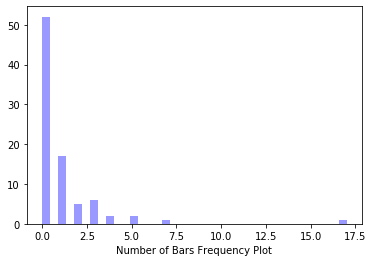

In [157]:
# How should we scale our data, well let's look at an example distribution.
#venues_grouped[['Bar','Italian Restaurant']].plot(kind='hist')
sns.distplot(venues_grouped[['Bar']],color='blue',kde=False, axlabel = 'Number of Bars Frequency Plot')

#### This is a non gaussian distribution that contains a significant outlier, therefore let's use a robust scaler that is less sensitive to outliers.

array([0.12633646, 0.22149794, 0.2985095 , 0.35990471, 0.41513214,
       0.46512132, 0.50512811, 0.54059482, 0.57199267, 0.60073017,
       0.62820862, 0.65268268, 0.67375976, 0.69354782, 0.7124609 ,
       0.72847087, 0.74388814, 0.75797844, 0.77179308, 0.78542113,
       0.79818207, 0.81015651, 0.82161613, 0.8320384 , 0.8422412 ,
       0.85192528, 0.86090629, 0.86932609, 0.87698099, 0.88427041])

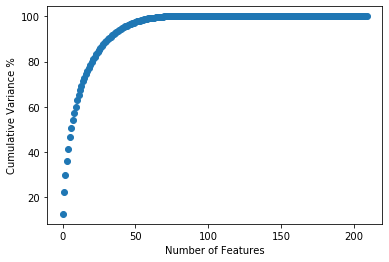

In [33]:
# Let's use the robust scalar to avoid being overly affected by outliers.
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# Singular Value Decomposition, let us see how many eignevalues of our grouped venue matrix describe a sufficient amount of the variance in our dataset
X = venues_grouped.drop('Neighborhood', 1)
X = scaler.fit_transform(X)

# Covariance Matrix of our data
data = np.cov(X.transpose())

#Eigen decomposition of our covariance matrix
evectors,evalues,_ = np.linalg.svd(data,full_matrices=False)
#Express eigenvalues in terms of how much variance they represent cumulatively
evalues = np.cumsum(evalues)
evalues /= evalues.max()

plt.scatter(range(evalues.shape[0]),evalues*100)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Variance %')
evalues[0:30]

In [48]:
# The top 30 components describe > 85% of the variance between neighborhoods, so let's use these to reduce our matrix for clustering.
P = evectors[0:30]
P.shape

(30, 210)

In [49]:
# Reduce the dimensionality of our variables and create final output, size = nSamples X nPrimaryFactors
XPCA = P.dot(X.transpose())
XPCA = XPCA.transpose()
XPCA.shape


(86, 30)

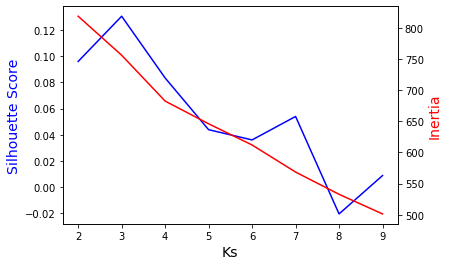

In [50]:
# find the best K with silhouette score and Inertia

Ks = 10 # number of ks we will test
SS = np.zeros((Ks-1))
inertia = np.zeros((Ks-1))

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for n in range(2, Ks):
    kmeans = KMeans(init='k-means++', n_clusters = n, random_state = 4, n_init=12).fit(XPCA)
    labels = kmeans.labels_
    SS[n-1] = silhouette_score(XPCA, labels, metric='cosine')
    inertia[n-1] = kmeans.inertia_

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(range(2,Ks),SS[1:],'b')
# set x-axis label
ax.set_xlabel("Ks",fontsize=14)
# set y-axis label
ax.set_ylabel("Silhouette Score",color="blue",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(2,Ks),inertia[1:],'r')
ax2.set_ylabel("Inertia",color="red",fontsize=14)

plt.show()

In [51]:
# set number of clusters to 4
nFinal = 4

# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters = nFinal, random_state = 4, n_init = 10).fit(XPCA)

# extract centres and check cluster labels generated for each row in the dataframe
kcenters = kmeans.cluster_centers_
kmeans.labels_ 


array([0, 2, 0, 0, 2, 2, 3, 0, 0, 0, 0, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [52]:
venues_grouped['Cluster Label'] = kmeans.labels_
venues_grouped.head(10)

Neighborhood  Accessories Store  African Restaurant  \
0  Barking and Dagenham                0.0                 0.0   
1                Barnet                0.0                 0.0   
2                Bexley                0.0                 0.0   
3                 Brent                0.0                 0.0   
4               Bromley                0.0                 0.0   
5            Bronx Park                0.0                 0.0   
6              Bushwick                0.0                 0.0   
7                Camden                0.0                 0.0   
8              Canarsie                0.0                 0.0   
9         Central Bronx                0.0                 2.0   

   American Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                  0.0                     0.0          0.0         0.0   
1                  0.0                     0.0          0.0         0.0   
2                  2.0                     0.0          0.0         0.0   
3                  2.0                     0.0          0.0         0.0   
4                  0.0                     0.0          0.0         0.0   
5                  0.0                     0.0          0.0         0.0   
6                  2.0                     0.0          0.0         0.0   
7                  1.0                     1.0          1.0         0.0   
8                  0.0                     0.0          0.0         0.0   
9                  0.0                     0.0          0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                  0.0               0.0                 0.0   
1                  0.0               0.0                 0.0   
2                  0.0               0.0                 0.0   
3                  0.0               1.0                 0.0   
4                  0.0               0.0                 0.0   
5                  0.0               0.0                 0.0   
6                  1.0               1.0                 0.0   
7                  1.0               0.0                 0.0   
8                  0.0               0.0                 0.0   
9                  0.0               0.0                 0.0   

   Australian Restaurant  Bagel Shop  Bakery   Bar  Beach  Bed & Breakfast  \
0                    0.0         0.0     0.0   0.0    0.0              0.0   
1                    0.0         0.0     1.0   0.0    0.0              0.0   
2                    0.0         0.0     1.0   1.0    0.0              0.0   
3                    0.0         0.0     0.0   5.0    0.0              0.0   
4                    0.0         0.0     1.0   0.0    0.0              0.0   
5                    0.0         0.0     0.0   1.0    0.0              0.0   
6                    0.0         2.0     4.0  17.0    0.0              0.0   
7                    0.0         0.0     2.0   0.0    0.0              0.0   
8                    0.0         2.0     1.0   0.0    0.0              0.0   
9                    0.0         0.0     6.0   1.0    0.0              0.0   

   Beer Bar  Beer Garden  Beer Store  Bike Shop  Bistro  Bookstore  \
0       0.0          0.0         0.0        0.0     0.0        0.0   
1       0.0          0.0         0.0        0.0     0.0        0.0   
2       0.0          0.0         0.0        0.0     0.0        0.0   
3       0.0          0.0         0.0        0.0     1.0        0.0   
4       0.0          0.0         0.0        0.0     0.0        0.0   
5       0.0          1.0         0.0        0.0     0.0        0.0   
6       1.0          0.0         0.0        0.0     0.0        0.0   
7       0.0          0.0         0.0        0.0     0.0        2.0   
8       0.0          0.0         0.0        0.0     0.0        0.0   
9       0.0          0.0         0.0        0.0     0.0        0.0   

   Border Crossing  Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  \
0              0.0       0.0            0.

In [53]:
# Let's analyse the commonalities of our clusters
df_c0 = venues_grouped.loc[venues_grouped['Cluster Label'] == 0].drop(columns = ['Cluster Label'])
df_c1 = venues_grouped.loc[venues_grouped['Cluster Label'] == 1].drop(columns = ['Cluster Label'])
df_c2 = venues_grouped.loc[venues_grouped['Cluster Label'] == 2].drop(columns = ['Cluster Label'])
df_c3 = venues_grouped.loc[venues_grouped['Cluster Label'] == 3].drop(columns = ['Cluster Label'])

In [54]:
# Assign Labels to Neighborhoods in our original dataframes to revisualise the cities:
df_clusters = venues_grouped[['Neighborhood','Cluster Label']]
df_clusters.shape

(86, 2)

In [55]:
l_lond = set(df_London['Neighborhood']) & set(df_clusters['Neighborhood'])
df_London['Cluster Label'] = df_clusters['Cluster Label'][df_clusters['Neighborhood'].isin(l_lond)].reset_index().drop(['index'],axis=1)

In [56]:
l_ny = set(df_NY['Neighborhood']) & set(df_clusters['Neighborhood'])
df_NY['Cluster Label'] = df_clusters['Cluster Label'][df_clusters['Neighborhood'].isin(l_ny)].reset_index().drop(['index'],axis=1)

In [57]:
# create map around London and View Clusters
map_clusters = folium.Map(location=[51.5074, -0.1278], zoom_start=10, width = '50%', height = '50%')

# set color scheme for the clusters
x = np.arange(nFinal)
ys = [i + x + (i*x)**2 for i in range(nFinal)]
colors_array = cm.seismic(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_London['Latitude'], df_London['Longitude'], df_London['Neighborhood'], df_London['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [59]:
# create map around London and View Clusters
map_clusters = folium.Map(location=[40.688, -73.906], zoom_start=10, width = '50%', height = '50%')

df = df_NY.dropna()

# set color scheme for the clusters
x = np.arange(nFinal)
ys = [i + x + (i*x)**2 for i in range(nFinal)]
colors_array = cm.seismic(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

#### We will try to isolate the most important features of each cluster to compare them on via boxplots

In [62]:
# Create a descending dataframe based on the mean count of each venue type
df_c0 = df_c0.reindex(df_c0.mean().sort_values(ascending=False).index, axis=1)
df_c1 = df_c1.reindex(df_c1.mean().sort_values(ascending=False).index, axis=1)
df_c2 = df_c2.reindex(df_c2.mean().sort_values(ascending=False).index, axis=1)
df_c3 = df_c3.reindex(df_c3.mean().sort_values(ascending=False).index, axis=1)

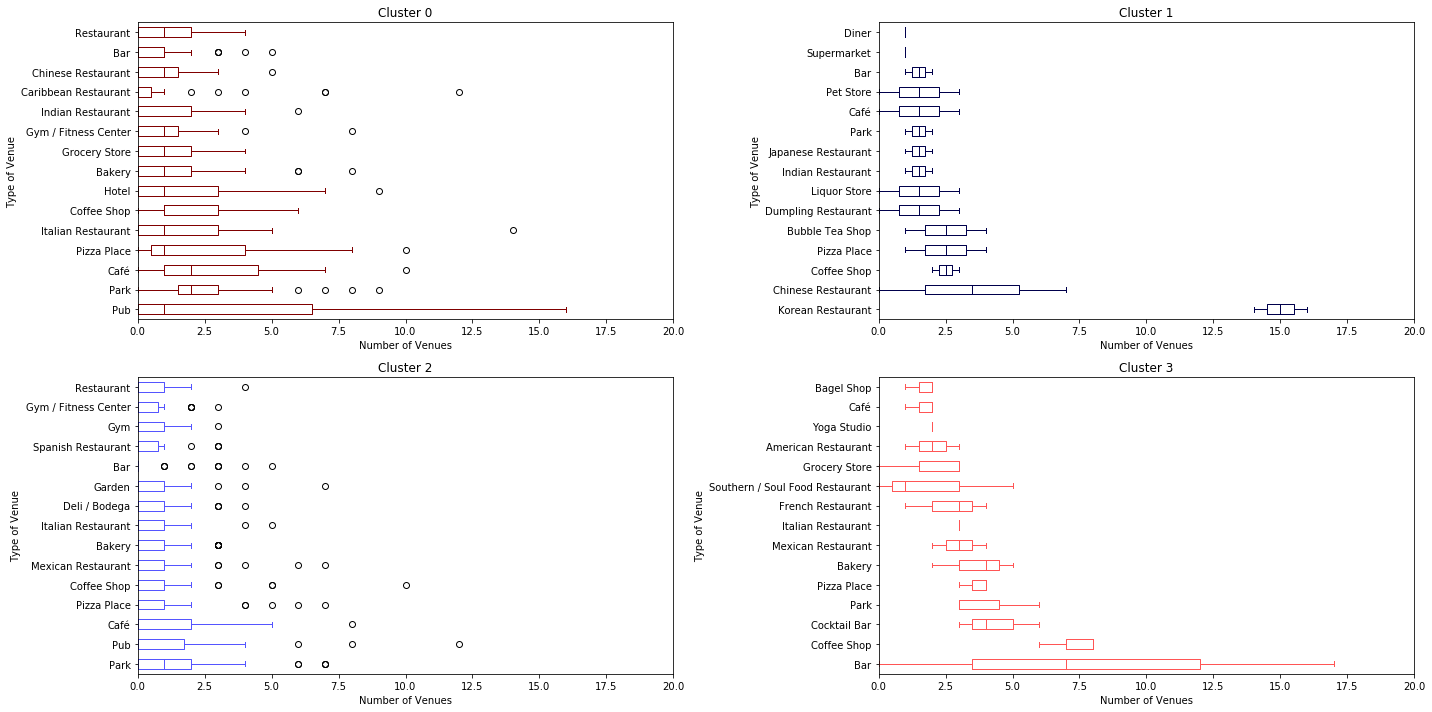

In [155]:
# Boxplot our significant venue types in each cluster, stacked and labelled within.
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10))

df_c0.iloc[:, : 15].plot(ax=axes[0,0],kind='box',legend=True,stacked=False,vert=False,xlim=(0,20),color=rainbow[-1])
axes[0, 0].set_title('Cluster 0')

df_c1.iloc[:, : 15].plot(ax=axes[0,1],kind='box',legend=True,stacked=False,vert=False,xlim=(0,20),color=rainbow[0])
axes[0, 1].set_title('Cluster 1')

df_c2.iloc[:, : 15].plot(ax=axes[1,0],kind='box',legend=True,stacked=False,vert=False,xlim=(0,20),color=rainbow[1])
axes[1, 0].set_title('Cluster 2')

df_c3.iloc[:, : 15].plot(ax=axes[1,1],kind='box',legend=True,stacked=False,vert=False,xlim=(0,20),color=rainbow[2])
axes[1, 1].set_title('Cluster 3')

for ax in axes.flat:
    ax.set(xlabel='Number of Venues', ylabel='Type of Venue')

plt.tight_layout()
plt.show()

In [64]:
print('Cluster 0 size is ' + str(df_c0.shape[0]) + ' out of ' + str(XPCA.shape[0]) + ' Neighborhoods')
print('Cluster 1 size is ' + str(df_c1.shape[0]) + ' out of ' + str(XPCA.shape[0]) + ' Neighborhoods')
print('Cluster 2 size is ' + str(df_c2.shape[0]) + ' out of ' + str(XPCA.shape[0]) + ' Neighborhoods')
print('Cluster 3 size is ' + str(df_c3.shape[0]) + ' out of ' + str(XPCA.shape[0]) + ' Neighborhoods')

Cluster 0 size is 35 out of 86 Neighborhoods
Cluster 1 size is 2 out of 86 Neighborhoods
Cluster 2 size is 46 out of 86 Neighborhoods
Cluster 3 size is 3 out of 86 Neighborhoods


#### Conclusions on clustering
Cluster 0 has Low average venue count < 2.5 but a wide range in density and dominated by pubs, cafes and parks.<br>
Cluster 1 is small cluster dominated by Asian cuisine.<br>
Cluster 2 is similar in nature to cluster 0 but with much lower density.<br>
Cluster 3 has Larger means > 2.5 and is a small cluster dominated by bars and coffee shops with large counts of different restaurant types.<br>


In [71]:
# Camden is in cluster 0 so we need to see which neighborhood in NY out of cluster 0 sits closest within our XPCA dataset

# Find Index of Camden
iCamden = venues_grouped.loc[venues_grouped['Neighborhood'] == 'Camden'].index[0]
print('Camden is neighborhood ' + str(iCamden))
# Print df_c0
df_c0.head()

Camden is neighborhood 7


Pub  Park  Café  Pizza Place  Italian Restaurant  Coffee Shop  Hotel  \
0   1.0   2.0   1.0          0.0                 0.0          0.0    0.0   
2  11.0   0.0   2.0          1.0                 2.0          3.0    2.0   
3   3.0   1.0   1.0          4.0                 1.0          1.0    7.0   
7   8.0   3.0  10.0          2.0                 4.0          2.0    0.0   
8   0.0   0.0   0.0          5.0                 0.0          0.0    0.0   

   Bakery  Grocery Store  Gym / Fitness Center  Indian Restaurant  \
0     0.0            3.0                   1.0                0.0   
2     1.0            0.0                   1.0                0.0   
3     0.0            1.0                   1.0                3.0   
7     2.0            2.0                   2.0                1.0   
8     1.0            2.0                   1.0                0.0   

   Caribbean Restaurant  Chinese Restaurant  Bar  Restaurant  Deli / Bodega  \
0                   0.0                 1.0  0.0         1.0            0.0   
2                   0.0                 2.0  1.0         0.0            0.0   
3                   0.0                 0.0  5.0         1.0            0.0   
7                   0.0                 1.0  0.0         0.0            3.0   
8                   7.0                 1.0  0.0         0.0            0.0   

   Ice Cream Shop  Thai Restaurant  Clothing Store  Gym  American Restaurant  \
0             0.0              0.0             1.0  0.0                  0.0   
2             0.0              0.0             4.0  0.0                  2.0   
3             1.0              1.0             4.0  0.0                  2.0   
7             2.0              2.0             1.0  0.0                  1.0   
8             0.0              0.0             0.0  0.0                  0.0   

   Supermarket  Gastropub  Sushi Restaurant  Japanese Restaurant  Bagel Shop  \
0          3.0        0.0               0.0                  0.0         0.0   
2          1.0        0.0               0.0                  0.0         0.0   
3          0.0        0.0               0.0                  0.0         0.0   
7          0.0        3.0               0.0                  1.0         0.0   
8          1.0        0.0               0.0                  0.0         2.0   

   Plaza  Cocktail Bar  Fast Food Restaurant  Playground  Sandwich Place  \
0    1.0           0.0                   0.0         0.0             0.0   
2    1.0           0.0                   3.0         0.0             1.0   
3    1.0           0.0                   0.0         0.0             2.0   
7    1.0           0.0                   0.0         0.0             0.0   
8    0.0           0.0                   0.0         3.0             1.0   

   Theater  Diner  Mediterranean Restaurant  Asian Restaurant  Wine Shop  \
0      0.0    0.0                       0.0               0.0        0.0   
2      0.0    0.0                       0.0               0.0        0.0   
3      0.0    1.0                       0.0               1.0        0.0   
7      1.0    1.0                       2.0               0.0        1.0   
8      0.0    1.0                       0.0               0.0        0.0   

   Breakfast Spot  Gourmet Shop  Beach  Juice Bar  Art Gallery  \
0             0.0           0.0    0.0        0.0          0.0   
2             0.0           0.0    0.0        0.0          0.0   
3             0.0           0.0    0.0        0.0          0.0   
7             0.0           0.0    0.0        0.0          1.0   
8             2.0           0.0    0.0        1.0          0.0   

   French Restaurant  Greek Restaurant  Liquor Store  Seafood Restaurant  \
0                0.0               0.0           0.0                 0.0   
2                0.0               0.0           0.0                 0.0   
3                0.0               0.0           0.0                 1.0   
7                0.0               1.0           0.0                 0.0   
8   

#### Find the closest euclidean neighbor to Index 8 within the XPCA dataset (SVD reduced dataset) for indices in df_c2

In [91]:
iLookup = df_c0.index.values
iLookup = iLookup[iLookup != iCamden]
iLookup

array([ 0,  2,  3,  8,  9, 10, 12, 13, 15, 17, 18, 19, 20, 22, 26, 27, 28,
       31, 32, 36, 37, 40, 41, 42, 43, 45, 49, 50, 53, 57, 67, 68, 69, 71])

In [101]:
from scipy import spatial

a = XPCA[iCamden]
imin = 0
distm = 1e8

# Lookup Our nearest data neighbor to Camden from New York

for i in iLookup:
    if df_NY['Neighborhood'].str.contains(str(venues_grouped.iloc[i]['Neighborhood'])).any():
        b = XPCA[i]
        dist = spatial.distance.cosine(b, a)
        if dist < distm:
            imin = i
            distm = dist

print(imin)

9


In [107]:
print('Closest Neighborhood by Cosine Distance from Camden in Cluster 2 is ' + str(venues_grouped.iloc[imin]['Neighborhood']) + ' which is Neighborhood ' + str(imin))

Closest Neighborhood by Cosine Distance from Camden in Cluster 2 is Central Bronx which is Neighborhood 9


In [127]:
df_FinalCompare = df_c0.iloc[3:4,: 15]
df_FinalCompare = df_FinalCompare.append(df_c0.iloc[5:6,:15]).rename(index={7:'Camden',9:'Central Bronx'})
df_FinalCompare

Pub  Park  Café  Pizza Place  Italian Restaurant  Coffee Shop  \
Camden         8.0   3.0  10.0          2.0                 4.0          2.0   
Central Bronx  0.0   3.0   2.0         10.0                14.0          0.0   

               Hotel  Bakery  Grocery Store  Gym / Fitness Center  \
Camden           0.0     2.0            2.0                   2.0   
Central Bronx    0.0     6.0            3.0                   1.0   

               Indian Restaurant  Caribbean Restaurant  Chinese Restaurant  \
Camden                       1.0                   0.0                 1.0   
Central Bronx                0.0                   0.0                 0.0   

               Bar  Restaurant  
Camden         0.0         0.0  
Central Bronx  1.0         0.0

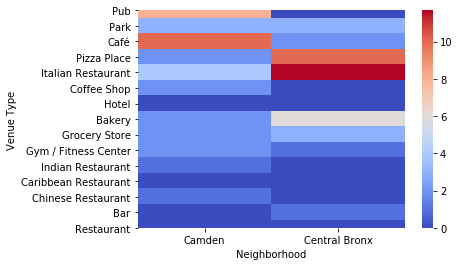

In [151]:
# Rotate our values for a more pleasing output
df_Plot = df_FinalCompare.transpose()

g = sns.heatmap(df_Plot, cmap='coolwarm',
                annot=False,
                fmt=".1f",
                annot_kws={'size':10},
                robust=True,
                cbar=True,
                square=False)

plt.ylabel('Venue Type')
plt.xlabel('Neighborhood')

plt.show(g)

### Conclusion on our final selection:
#### In General correlation is good in terms of the amount of venues in our key categories within this cluster, there is a noted difference in that Pubs and Cafes are more prevalent in Camden whereas Italian and Pizzerias are more prevalent in the Bronx. This is probably an expected difference given the nature of the UK and New York cultures.